This notebook uses the library Keras to generalize the problem of the ML_cup 2022.

The notebook uses the following hyperparameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

2022-11-23 22:52:00.514213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 22:52:01.293734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 22:52:01.293784: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-23 22:52:01.426382: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-23 22:52:04.262249: W tensorflow/stream_executor/platform/de

Loading data for the ML cup 2022

In [2]:
# set a fixed seed
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [4]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

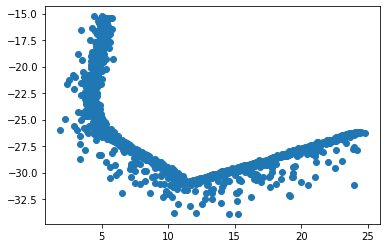

In [5]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

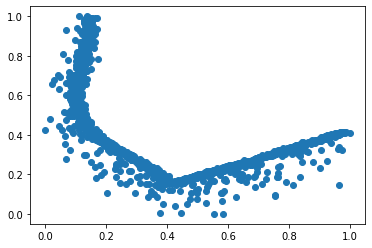

In [7]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [8]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [9]:
# This function computes the mean euclidean distance for Keras
def euclidean_distance(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    n_points = float(len(y_true))
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) / n_points

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [10]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, ridge_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L2(ridge_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L2(ridge_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(ridge_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=2, max_units=11, min_ridge_lambda=0.0001, max_ridge_lambda=0.1, min_lr_rate=0.05, 
                max_lr_rate=0.15, min_mom=0.0, max_mom=0.8, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    ridge_lambda_sampling = "log"
    if(linear_reg):
        ridge_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units >= 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'ridge_lambda' represents the lambda coefficient for ridge regularization
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    ridge_lambda = hp.Float(
        "ridge_lambda", min_value=min_ridge_lambda, max_value=max_ridge_lambda, sampling=ridge_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, ridge_lambda=ridge_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [11]:
br_l = lambda a : build_regressor(a, my_metric=euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts 
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

2022-11-23 22:52:10.889020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-23 22:52:10.889438: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-23 22:52:10.889527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-11-23 22:52:10.890676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [13]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 00m 24s]
val_euclidean_distance: 0.005942785336325566

Best val_euclidean_distance So Far: 0.002814775953690211
Total elapsed time: 01h 28m 08s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 11
ridge_lambda 0.015804341564857032
learning_rate 0.07911507143545164
momentum 0.7626486557073276

best hyperparameters n. 1
units 11
ridge_lambda 0.0009143526994781964
learning_rate 0.07483463800084061
momentum 0.6298027833106152

best hyperparameters n. 2
units 8
ridge_lambda 0.008419190921668917
learning_rate 0.05333652147540091
momentum 0.4785532818300392



Brief description of the final neural network's structure

In [15]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


In [16]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.015804341564857032
learning_rate: 0.07911507143545164
momentum: 0.7626486557073276
Score: 0.002814775953690211
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.0009143526994781964
learning_rate: 0.07483463800084061
momentum: 0.6298027833106152
Score: 0.0028669135256980858
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.008419190921668917
learning_rate: 0.05333652147540091
momentum: 0.4785532818300392
Score: 0.002873589633964002
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.00015550921794612785
learning_rate: 0.1366360520768815
momentum: 0.7425008378929796
Score: 0.002891525315741698
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.02335168294647637
learning_rate: 0.08529867113772965
momentum: 0.0837496099325156
Score: 0.0029287694099669657
Trial summary
Hyperparameters:
units: 11
ridge_lambd

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [17]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
ridge_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance,
    min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3 # number of folds of the cross validation
)

Again, below there is a brief summary of the search space

In [18]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 11, 'max_value': 11, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.012643473251885626, 'conditions': [], 'min_value': 0.012643473251885626, 'max_value': 0.01896520987782844, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.06329205714836131, 'conditions': [], 'min_value': 0.06329205714836131, 'max_value': 0.09493808572254196, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.6101189245658621, 'conditions': [], 'min_value': 0.6101189245658621, 'max_value': 0.9151783868487933, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [19]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 01m 04s]
val_euclidean_distance: 0.002842419780790806

Best val_euclidean_distance So Far: 0.0027430637661988535
Total elapsed time: 00h 38m 42s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [20]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 11
ridge_lambda 0.016876681179600173
learning_rate 0.07449133492518882
momentum 0.6945352072197624

best hyperparameters n. 1
units 11
ridge_lambda 0.015684007113347668
learning_rate 0.0693545607803998
momentum 0.6139687604826913

best hyperparameters n. 2
units 11
ridge_lambda 0.014538187183876686
learning_rate 0.09423851779879583
momentum 0.8017685753896422



Brief description of the final neural network's structure

In [21]:
br_l2 = lambda a : build_regressor(a, my_metric=euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [22]:
subset_size = int(0.3 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [23]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 1s 6ms/step - loss: 0.0780 - euclidean_distance: 0.0084 - val_loss: 0.0349 - val_euclidean_distance: 0.0057
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0317 - euclidean_distance: 0.0055 - val_loss: 0.0271 - val_euclidean_distance: 0.0050
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0269 - euclidean_distance: 0.0049 - val_loss: 0.0245 - val_euclidean_distance: 0.0047
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0252 - euclidean_distance: 0.0047 - val_loss: 0.0233 - val_euclidean_distance: 0.0046
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0238 - euclidean_distance: 0.0045 - val_loss: 0.0218 - val_euclidean_distance: 0.0042
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0226 - euclidean_distance: 0.0043 - val_loss: 0.0214 - val_euclidean_distance: 0.0041
Epoch 7/1000
33/33 [========

33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0028 - val_loss: 0.0140 - val_euclidean_distance: 0.0027
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0028 - val_loss: 0.0140 - val_euclidean_distance: 0.0027
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0029
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0028 - val_loss: 0.0141 - val_euclidean_distance: 0.0028
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0028 - val_loss: 0.0142 - val_euclidean_distance: 0.0030
Epoch 107/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - euclidean_distance: 0.0036 - val_loss: 0.0184 - val_euclidean_distance: 0.0035
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - euclidean_distance: 0.0036 - val_loss: 0.0184 - val_euclidean_distance: 0.0035
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - euclidean_distance: 0.0035 - val_loss: 0.0186 - val_euclidean_distance: 0.0036
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - euclidean_distance: 0.0035 - val_loss: 0.0180 - val_euclidean_distance: 0.0035
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0184 - euclidean_distance: 0.0035 - val_loss: 0.0177 - val_euclidean_distance: 0.0034
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0183 - euclidean_distance: 0.0034 - val_loss: 0.0175 - val_euclidean_distance: 0.0033
Epoch 21/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0142 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0027
Epoch 116/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 117/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0028 - val_loss: 0.0143 - val_euclidean_distance: 0.0028
Epoch 118/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 119/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0142 - euclidean_distance: 0.0028 - val_loss: 0.0141 - val_euclidean_distance: 0.0027
Epoch 120/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 121/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0029 - val_loss: 0.0142 - val_euclidean_distance: 0.0028
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0029 - val_loss: 0.0143 - val_euclidean_distance: 0.0029
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0028 - val_loss: 0.0141 - val_euclidean_distance: 0.0028
Epoch 68/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0028 - val_loss: 0.0142 - val_euclidean_distance: 0.0029
Epoch 69/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0028 - val_loss: 0.0142 - val_euclidean_distance: 0.0028
Epoch 70/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0028
Epoch 71/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0294 - euclidean_distance: 0.0048 - val_loss: 0.0250 - val_euclidean_distance: 0.0043
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0248 - euclidean_distance: 0.0043 - val_loss: 0.0224 - val_euclidean_distance: 0.0040
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0228 - euclidean_distance: 0.0040 - val_loss: 0.0214 - val_euclidean_distance: 0.0039
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0219 - euclidean_distance: 0.0039 - val_loss: 0.0205 - val_euclidean_distance: 0.0038
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0212 - euclidean_distance: 0.0038 - val_loss: 0.0207 - val_euclidean_distance: 0.0038
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0209 - euclidean_distance: 0.0038 - val_loss: 0.0197 - val_euclidean_distance: 0.0037
Epoch 8/1000
33/33 [=====================

33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0029 - val_loss: 0.0145 - val_euclidean_distance: 0.0028
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0028 - val_loss: 0.0141 - val_euclidean_distance: 0.0028
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0028 - val_loss: 0.0145 - val_euclidean_distance: 0.0030
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0028 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0028 - val_loss: 0.0142 - val_euclidean_distance: 0.0030
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0029
Epoch 108/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.0030 - val_loss: 0.0148 - val_euclidean_distance: 0.0029
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.0030 - val_loss: 0.0157 - val_euclidean_distance: 0.0033
Epoch 57/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0153 - euclidean_distance: 0.0030 - val_loss: 0.0154 - val_euclidean_distance: 0.0031
Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0153 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0030
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0153 - euclidean_distance: 0.0030 - val_loss: 0.0152 - val_euclidean_distance: 0.0030
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0152 - euclidean_distance: 0.0030 - val_loss: 0.0146 - val_euclidean_distance: 0.0029
Epoch 61/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0221 - euclidean_distance: 0.0044 - val_loss: 0.0208 - val_euclidean_distance: 0.0042
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0212 - euclidean_distance: 0.0042 - val_loss: 0.0209 - val_euclidean_distance: 0.0043
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0207 - euclidean_distance: 0.0041 - val_loss: 0.0196 - val_euclidean_distance: 0.0040
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0203 - euclidean_distance: 0.0040 - val_loss: 0.0193 - val_euclidean_distance: 0.0039
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0198 - euclidean_distance: 0.0038 - val_loss: 0.0192 - val_euclidean_distance: 0.0039
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0196 - euclidean_distance: 0.0038 - val_loss: 0.0189 - val_euclidean_distance: 0.0038
Epoch 11/1000
33/33 [===================

33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0028 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0028 - val_loss: 0.0143 - val_euclidean_distance: 0.0031
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 1/1000
33/33 [==============================] - 1s 6ms/step - loss: 0.0893 - euclidean_distance: 0.0090 - val_loss: 0.0323 - val_euclidean_distance: 0.0056
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0296 - euclidean_distance: 0.0053 - val_loss: 0.0279 - val_euclidean_distance: 0.0051
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0274 - euclidean_distance: 0.0050 - val_loss: 0.0269 - val_euclidean_distance: 0.0050
Epoch 4/1000
33/33 [=================

33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0142 - val_euclidean_distance: 0.0029
Epoch 99/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0030 - val_loss: 0.0143 - val_euclidean_distance: 0.0029
Epoch 100/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0030 - val_loss: 0.0142 - val_euclidean_distance: 0.0028
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0145 - val_euclidean_distance: 0.0029
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0030 - val_loss: 0.0149 - val_euclidean_distance: 0.0028
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0029 - val_loss: 0.0143 - val_euclidean_distance: 0.0029
Epoch 104/1000
33/33 [==========

33/33 [==============================] - 0s 2ms/step - loss: 0.0320 - euclidean_distance: 0.0054 - val_loss: 0.0295 - val_euclidean_distance: 0.0052
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0297 - euclidean_distance: 0.0052 - val_loss: 0.0280 - val_euclidean_distance: 0.0051
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0281 - euclidean_distance: 0.0050 - val_loss: 0.0263 - val_euclidean_distance: 0.0048
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0268 - euclidean_distance: 0.0048 - val_loss: 0.0257 - val_euclidean_distance: 0.0048
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0257 - euclidean_distance: 0.0046 - val_loss: 0.0244 - val_euclidean_distance: 0.0046
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0248 - euclidean_distance: 0.0046 - val_loss: 0.0233 - val_euclidean_distance: 0.0044
Epoch 9/1000
33/33 [=====================

33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0028 - val_loss: 0.0140 - val_euclidean_distance: 0.0029
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0029
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0028 - val_loss: 0.0141 - val_euclidean_distance: 0.0029
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0029 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 108/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0028
Epoch 1/1000
33/33 [===========

33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0028
Epoch 96/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0140 - val_euclidean_distance: 0.0028
Epoch 97/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0027
Epoch 98/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0027
Epoch 99/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0028
Epoch 100/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0027
Epoch 101/1000
33/33 [=============

33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0027 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 146/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0028 - val_loss: 0.0135 - val_euclidean_distance: 0.0028
Epoch 147/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0027 - val_loss: 0.0136 - val_euclidean_distance: 0.0028
Epoch 148/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0028 - val_loss: 0.0136 - val_euclidean_distance: 0.0028
Epoch 149/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0027 - val_loss: 0.0137 - val_euclidean_distance: 0.0028
Epoch 150/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0029


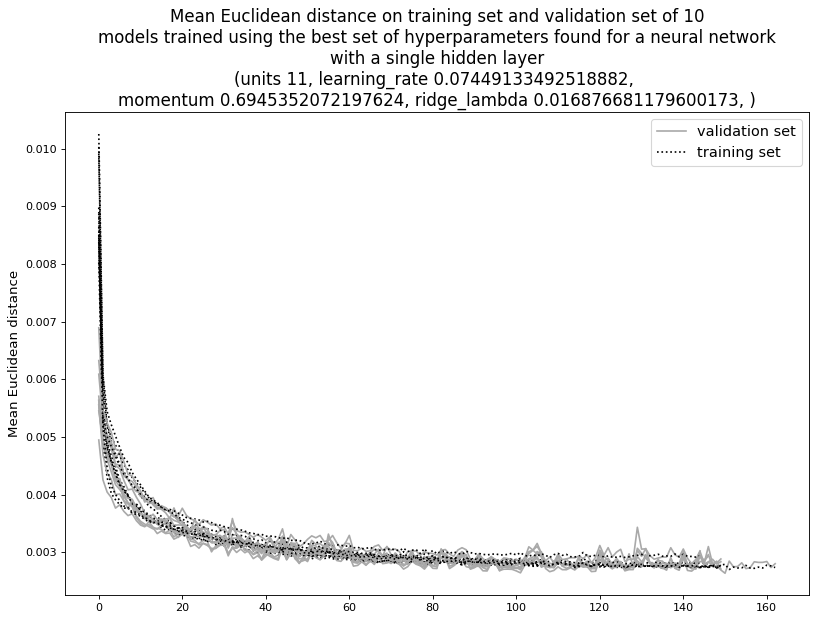

In [24]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']
    list_values_tr[i] = hist[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png")
plt.show()

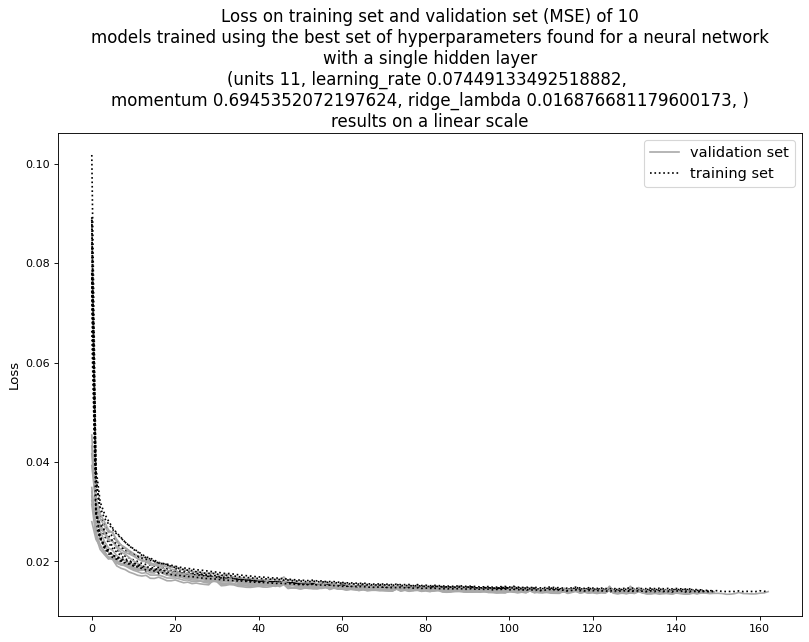

In [25]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

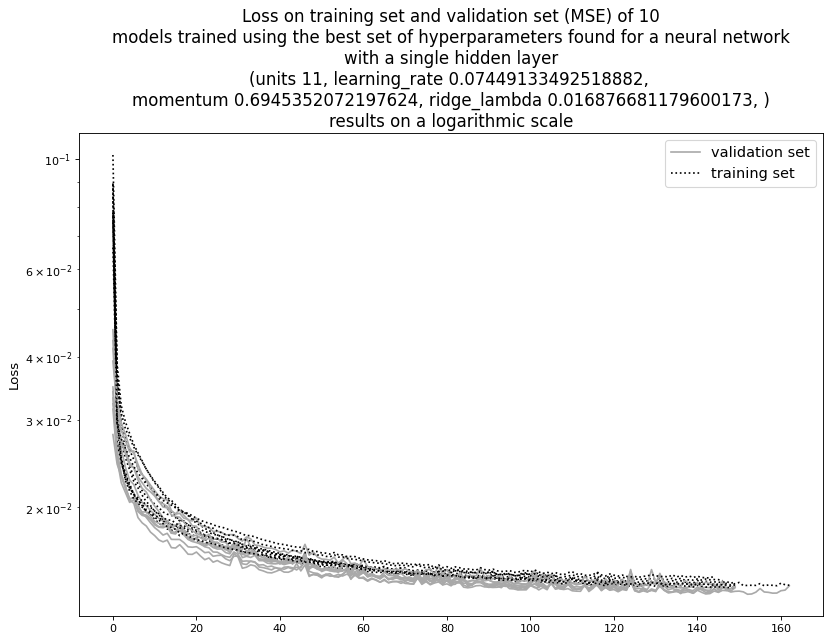

In [26]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [27]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 2
num_units_max = 5
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [28]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [29]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 00m 32s]
val_euclidean_distance: 0.005978243115047614

Best val_euclidean_distance So Far: 0.0028913787100464106
Total elapsed time: 00h 42m 24s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 5
ridge_lambda 0.014348090036477402
learning_rate 0.05398603554089731
momentum 0.25318909928420336

best hyperparameters n. 1
units 5
ridge_lambda 0.011604194983845371
learning_rate 0.0753574901304801
momentum 0.6158699933784664

best hyperparameters n. 2
units 5
ridge_lambda 0.00021552460794491737
learning_rate 0.10504981927921822
momentum 0.053604778630793694



Brief description of the final neural network's structure

In [31]:
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 50        
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 2)                 12        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [32]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.014348090036477402
learning_rate: 0.05398603554089731
momentum: 0.25318909928420336
Score: 0.0028913787100464106
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.011604194983845371
learning_rate: 0.0753574901304801
momentum: 0.6158699933784664
Score: 0.0030224331033726535
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.00021552460794491737
learning_rate: 0.10504981927921822
momentum: 0.053604778630793694
Score: 0.0030273505253717303
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.007321075703332613
learning_rate: 0.06909421152535274
momentum: 0.4465917027665972
Score: 0.0030607888863111534
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.008910680209979078
learning_rate: 0.09450157833364378
momentum: 0.023064460424602196
Score: 0.0032266335329040885
Trial summary
Hyperparameters:
units: 4
ridge_l

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [33]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
ridge_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, 
    min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3
)

Again, below there is a brief summary of the search space

In [34]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 5, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.01147847202918192, 'conditions': [], 'min_value': 0.01147847202918192, 'max_value': 0.01721770804377288, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.043188828432717846, 'conditions': [], 'min_value': 0.043188828432717846, 'max_value': 0.06478324264907677, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.20255127942736267, 'conditions': [], 'min_value': 0.20255127942736267, 'max_value': 0.303826919141044, 'step': None, 'sampling': 'linear'}


In [35]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 01m 37s]
val_euclidean_distance: 0.0032797441429769

Best val_euclidean_distance So Far: 0.002916820269698898
Total elapsed time: 01h 22m 58s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [36]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 5
ridge_lambda 0.013302588474787647
learning_rate 0.049287709199310074
momentum 0.2923965744697992

best hyperparameters n. 1
units 5
ridge_lambda 0.013453223528690383
learning_rate 0.046754893318287534
momentum 0.21727888522515412

best hyperparameters n. 2
units 5
ridge_lambda 0.012740132283086729
learning_rate 0.05587063586061961
momentum 0.22059043113460614



Brief description of the final neural network's structure

In [37]:
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 50        
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 2)                 12        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [38]:
subset_size = int(0.3 * len(x_mlcup_tr))

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [39]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 1s 8ms/step - loss: 0.1127 - euclidean_distance: 0.0118 - val_loss: 0.0733 - val_euclidean_distance: 0.0095
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0734 - euclidean_distance: 0.0097 - val_loss: 0.0647 - val_euclidean_distance: 0.0089
Epoch 3/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0650 - euclidean_distance: 0.0091 - val_loss: 0.0588 - val_euclidean_distance: 0.0085
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0577 - euclidean_distance: 0.0085 - val_loss: 0.0509 - val_euclidean_distance: 0.0077
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0511 - euclidean_distance: 0.0078 - val_loss: 0.0451 - val_euclidean_distance: 0.0071
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0452 - euclidean_distance: 0.0072 - val_loss: 0.0407 - val_euclidean_distance: 0.0066
Epoch 7/1000
33/33 [========

33/33 [==============================] - 0s 2ms/step - loss: 0.0157 - euclidean_distance: 0.0031 - val_loss: 0.0150 - val_euclidean_distance: 0.0030
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0157 - euclidean_distance: 0.0031 - val_loss: 0.0151 - val_euclidean_distance: 0.0030
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0030 - val_loss: 0.0150 - val_euclidean_distance: 0.0030
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0030 - val_loss: 0.0150 - val_euclidean_distance: 0.0030
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0030 - val_loss: 0.0149 - val_euclidean_distance: 0.0030
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0155 - euclidean_distance: 0.0030 - val_loss: 0.0149 - val_euclidean_distance: 0.0030
Epoch 107/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0028
Epoch 152/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0028 - val_loss: 0.0139 - val_euclidean_distance: 0.0029
Epoch 153/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0029 - val_loss: 0.0139 - val_euclidean_distance: 0.0028
Epoch 154/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0029 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 155/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0029 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 156/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0029 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 157/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0027
Epoch 202/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0027
Epoch 203/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0027
Epoch 204/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 205/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0027
Epoch 206/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0027
Epoch 207/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0027 - val_loss: 0.0130 - val_euclidean_distance: 0.0028
Epoch 252/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0027 - val_loss: 0.0129 - val_euclidean_distance: 0.0027
Epoch 253/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0027 - val_loss: 0.0132 - val_euclidean_distance: 0.0027
Epoch 254/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0027 - val_loss: 0.0129 - val_euclidean_distance: 0.0027
Epoch 255/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0027 - val_loss: 0.0128 - val_euclidean_distance: 0.0026
Epoch 256/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0027 - val_loss: 0.0128 - val_euclidean_distance: 0.0026
Epoch 257/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.0026 - val_loss: 0.0129 - val_euclidean_distance: 0.0026
Epoch 302/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.0027 - val_loss: 0.0126 - val_euclidean_distance: 0.0026
Epoch 303/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.0026 - val_loss: 0.0127 - val_euclidean_distance: 0.0027
Epoch 304/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.0027 - val_loss: 0.0127 - val_euclidean_distance: 0.0026
Epoch 305/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.0027 - val_loss: 0.0132 - val_euclidean_distance: 0.0026
Epoch 306/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.0026 - val_loss: 0.0126 - val_euclidean_distance: 0.0027
Epoch 307/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0129 - euclidean_distance: 0.0026 - val_loss: 0.0125 - val_euclidean_distance: 0.0027
Epoch 352/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0026 - val_loss: 0.0126 - val_euclidean_distance: 0.0027
Epoch 353/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0026 - val_loss: 0.0124 - val_euclidean_distance: 0.0026
Epoch 354/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129 - euclidean_distance: 0.0026 - val_loss: 0.0126 - val_euclidean_distance: 0.0026
Epoch 355/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0026 - val_loss: 0.0124 - val_euclidean_distance: 0.0026
Epoch 356/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.0026 - val_loss: 0.0126 - val_euclidean_distance: 0.0026
Epoch 357/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0126 - euclidean_distance: 0.0026 - val_loss: 0.0122 - val_euclidean_distance: 0.0026
Epoch 402/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.0026 - val_loss: 0.0128 - val_euclidean_distance: 0.0026
Epoch 403/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.0026 - val_loss: 0.0131 - val_euclidean_distance: 0.0026
Epoch 404/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.0026 - val_loss: 0.0122 - val_euclidean_distance: 0.0026
Epoch 405/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.0026 - val_loss: 0.0124 - val_euclidean_distance: 0.0026
Epoch 406/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0126 - euclidean_distance: 0.0026 - val_loss: 0.0123 - val_euclidean_distance: 0.0027
Epoch 407/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0248 - euclidean_distance: 0.0051 - val_loss: 0.0237 - val_euclidean_distance: 0.0050
Epoch 85/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0247 - euclidean_distance: 0.0051 - val_loss: 0.0237 - val_euclidean_distance: 0.0050
Epoch 86/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0247 - euclidean_distance: 0.0051 - val_loss: 0.0234 - val_euclidean_distance: 0.0049
Epoch 87/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0246 - euclidean_distance: 0.0051 - val_loss: 0.0235 - val_euclidean_distance: 0.0049
Epoch 88/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0246 - euclidean_distance: 0.0051 - val_loss: 0.0233 - val_euclidean_distance: 0.0049
Epoch 89/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0246 - euclidean_distance: 0.0051 - val_loss: 0.0236 - val_euclidean_distance: 0.0050
Epoch 90/1000
33/33 [===============

33/33 [==============================] - 0s 3ms/step - loss: 0.0211 - euclidean_distance: 0.0044 - val_loss: 0.0197 - val_euclidean_distance: 0.0042
Epoch 185/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0210 - euclidean_distance: 0.0044 - val_loss: 0.0209 - val_euclidean_distance: 0.0044
Epoch 186/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0209 - euclidean_distance: 0.0044 - val_loss: 0.0197 - val_euclidean_distance: 0.0042
Epoch 187/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0210 - euclidean_distance: 0.0044 - val_loss: 0.0203 - val_euclidean_distance: 0.0044
Epoch 188/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0209 - euclidean_distance: 0.0044 - val_loss: 0.0198 - val_euclidean_distance: 0.0042
Epoch 189/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0209 - euclidean_distance: 0.0044 - val_loss: 0.0198 - val_euclidean_distance: 0.0043
Epoch 190/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0199 - euclidean_distance: 0.0041 - val_loss: 0.0188 - val_euclidean_distance: 0.0040
Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - euclidean_distance: 0.0041 - val_loss: 0.0189 - val_euclidean_distance: 0.0040
Epoch 236/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0199 - euclidean_distance: 0.0041 - val_loss: 0.0185 - val_euclidean_distance: 0.0039
Epoch 237/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0199 - euclidean_distance: 0.0041 - val_loss: 0.0186 - val_euclidean_distance: 0.0039
Epoch 238/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - euclidean_distance: 0.0041 - val_loss: 0.0189 - val_euclidean_distance: 0.0040
Epoch 239/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0199 - euclidean_distance: 0.0041 - val_loss: 0.0185 - val_euclidean_distance: 0.0039
Epoch 240/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0190 - euclidean_distance: 0.0039 - val_loss: 0.0192 - val_euclidean_distance: 0.0041
Epoch 285/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0192 - euclidean_distance: 0.0039 - val_loss: 0.0189 - val_euclidean_distance: 0.0041
Epoch 286/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - euclidean_distance: 0.0039 - val_loss: 0.0187 - val_euclidean_distance: 0.0038
Epoch 287/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - euclidean_distance: 0.0039 - val_loss: 0.0182 - val_euclidean_distance: 0.0039
Epoch 288/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - euclidean_distance: 0.0039 - val_loss: 0.0179 - val_euclidean_distance: 0.0037
Epoch 289/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0190 - euclidean_distance: 0.0039 - val_loss: 0.0182 - val_euclidean_distance: 0.0039
Epoch 290/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0187 - euclidean_distance: 0.0039 - val_loss: 0.0176 - val_euclidean_distance: 0.0037
Epoch 335/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0187 - euclidean_distance: 0.0039 - val_loss: 0.0175 - val_euclidean_distance: 0.0037
Epoch 336/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - euclidean_distance: 0.0039 - val_loss: 0.0187 - val_euclidean_distance: 0.0040
Epoch 337/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0187 - euclidean_distance: 0.0039 - val_loss: 0.0174 - val_euclidean_distance: 0.0037
Epoch 338/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0189 - euclidean_distance: 0.0039 - val_loss: 0.0174 - val_euclidean_distance: 0.0036
Epoch 339/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - euclidean_distance: 0.0039 - val_loss: 0.0176 - val_euclidean_distance: 0.0036
Epoch 340/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - euclidean_distance: 0.0038 - val_loss: 0.0173 - val_euclidean_distance: 0.0037
Epoch 385/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - euclidean_distance: 0.0039 - val_loss: 0.0175 - val_euclidean_distance: 0.0036
Epoch 386/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0187 - euclidean_distance: 0.0039 - val_loss: 0.0172 - val_euclidean_distance: 0.0036
Epoch 387/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - euclidean_distance: 0.0038 - val_loss: 0.0179 - val_euclidean_distance: 0.0039
Epoch 388/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - euclidean_distance: 0.0039 - val_loss: 0.0173 - val_euclidean_distance: 0.0037
Epoch 389/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0186 - euclidean_distance: 0.0039 - val_loss: 0.0173 - val_euclidean_distance: 0.0036
Epoch 390/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0273 - euclidean_distance: 0.0053 - val_loss: 0.0266 - val_euclidean_distance: 0.0053
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0272 - euclidean_distance: 0.0053 - val_loss: 0.0265 - val_euclidean_distance: 0.0053
Epoch 75/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0271 - euclidean_distance: 0.0053 - val_loss: 0.0263 - val_euclidean_distance: 0.0052
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0270 - euclidean_distance: 0.0053 - val_loss: 0.0262 - val_euclidean_distance: 0.0052
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0269 - euclidean_distance: 0.0053 - val_loss: 0.0261 - val_euclidean_distance: 0.0052
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0268 - euclidean_distance: 0.0053 - val_loss: 0.0260 - val_euclidean_distance: 0.0052
Epoch 79/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0169 - euclidean_distance: 0.0034 - val_loss: 0.0166 - val_euclidean_distance: 0.0034
Epoch 174/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0168 - euclidean_distance: 0.0033 - val_loss: 0.0170 - val_euclidean_distance: 0.0035
Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0168 - euclidean_distance: 0.0033 - val_loss: 0.0167 - val_euclidean_distance: 0.0034
Epoch 176/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0167 - euclidean_distance: 0.0033 - val_loss: 0.0170 - val_euclidean_distance: 0.0035
Epoch 177/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0167 - euclidean_distance: 0.0033 - val_loss: 0.0165 - val_euclidean_distance: 0.0033
Epoch 178/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0167 - euclidean_distance: 0.0033 - val_loss: 0.0165 - val_euclidean_distance: 0.0034
Epoch 179/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0032 - val_loss: 0.0156 - val_euclidean_distance: 0.0033
Epoch 224/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0032 - val_loss: 0.0154 - val_euclidean_distance: 0.0031
Epoch 225/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0031
Epoch 226/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0031 - val_loss: 0.0153 - val_euclidean_distance: 0.0031
Epoch 227/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0032 - val_loss: 0.0156 - val_euclidean_distance: 0.0033
Epoch 228/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0156 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0032
Epoch 229/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0150 - val_euclidean_distance: 0.0031
Epoch 274/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0031
Epoch 275/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0031 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 276/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 277/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0030 - val_loss: 0.0144 - val_euclidean_distance: 0.0031
Epoch 278/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0030 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 279/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.0030 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 324/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.0029 - val_loss: 0.0139 - val_euclidean_distance: 0.0030
Epoch 325/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.0029 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 326/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.0029 - val_loss: 0.0140 - val_euclidean_distance: 0.0029
Epoch 327/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.0029 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 328/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.0029 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 329/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0028 - val_loss: 0.0136 - val_euclidean_distance: 0.0030
Epoch 374/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0029 - val_loss: 0.0135 - val_euclidean_distance: 0.0029
Epoch 375/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0029 - val_loss: 0.0133 - val_euclidean_distance: 0.0029
Epoch 376/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0029
Epoch 377/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0028 - val_loss: 0.0135 - val_euclidean_distance: 0.0029
Epoch 378/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0028 - val_loss: 0.0134 - val_euclidean_distance: 0.0029
Epoch 379/1000
33/33 [=========

33/33 [==============================] - 0s 4ms/step - loss: 0.0207 - euclidean_distance: 0.0039 - val_loss: 0.0199 - val_euclidean_distance: 0.0038
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0206 - euclidean_distance: 0.0039 - val_loss: 0.0200 - val_euclidean_distance: 0.0038
Epoch 75/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0205 - euclidean_distance: 0.0038 - val_loss: 0.0197 - val_euclidean_distance: 0.0038
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0204 - euclidean_distance: 0.0038 - val_loss: 0.0196 - val_euclidean_distance: 0.0038
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0203 - euclidean_distance: 0.0038 - val_loss: 0.0196 - val_euclidean_distance: 0.0038
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0202 - euclidean_distance: 0.0038 - val_loss: 0.0197 - val_euclidean_distance: 0.0038
Epoch 79/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0161 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0031
Epoch 174/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0160 - euclidean_distance: 0.0032 - val_loss: 0.0155 - val_euclidean_distance: 0.0032
Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0160 - euclidean_distance: 0.0032 - val_loss: 0.0155 - val_euclidean_distance: 0.0032
Epoch 176/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0160 - euclidean_distance: 0.0032 - val_loss: 0.0155 - val_euclidean_distance: 0.0032
Epoch 177/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0159 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0031
Epoch 178/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0159 - euclidean_distance: 0.0032 - val_loss: 0.0152 - val_euclidean_distance: 0.0031
Epoch 179/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 224/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 225/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0144 - val_euclidean_distance: 0.0030
Epoch 226/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0031 - val_loss: 0.0143 - val_euclidean_distance: 0.0030
Epoch 227/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0031 - val_loss: 0.0143 - val_euclidean_distance: 0.0030
Epoch 228/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0031 - val_loss: 0.0143 - val_euclidean_distance: 0.0030
Epoch 229/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0029
Epoch 274/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0030 - val_loss: 0.0140 - val_euclidean_distance: 0.0029
Epoch 275/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0030 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 276/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0030 - val_loss: 0.0138 - val_euclidean_distance: 0.0029
Epoch 277/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.0030 - val_loss: 0.0138 - val_euclidean_distance: 0.0029
Epoch 278/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0142 - euclidean_distance: 0.0030 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 279/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0029
Epoch 324/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0137 - val_euclidean_distance: 0.0029
Epoch 325/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 326/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0138 - val_euclidean_distance: 0.0029
Epoch 327/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 328/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0133 - val_euclidean_distance: 0.0029
Epoch 329/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0029
Epoch 374/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 375/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0131 - val_euclidean_distance: 0.0028
Epoch 376/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0131 - val_euclidean_distance: 0.0028
Epoch 377/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 378/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0029 - val_loss: 0.0134 - val_euclidean_distance: 0.0029
Epoch 379/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0248 - euclidean_distance: 0.0050 - val_loss: 0.0234 - val_euclidean_distance: 0.0049
Epoch 57/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0246 - euclidean_distance: 0.0050 - val_loss: 0.0232 - val_euclidean_distance: 0.0049
Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0245 - euclidean_distance: 0.0050 - val_loss: 0.0230 - val_euclidean_distance: 0.0048
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0243 - euclidean_distance: 0.0049 - val_loss: 0.0230 - val_euclidean_distance: 0.0048
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0241 - euclidean_distance: 0.0049 - val_loss: 0.0227 - val_euclidean_distance: 0.0048
Epoch 61/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0239 - euclidean_distance: 0.0048 - val_loss: 0.0226 - val_euclidean_distance: 0.0048
Epoch 62/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0163 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0032
Epoch 157/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.0032 - val_loss: 0.0154 - val_euclidean_distance: 0.0032
Epoch 158/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0032
Epoch 159/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0161 - euclidean_distance: 0.0032 - val_loss: 0.0153 - val_euclidean_distance: 0.0032
Epoch 160/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0160 - euclidean_distance: 0.0032 - val_loss: 0.0152 - val_euclidean_distance: 0.0032
Epoch 161/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0161 - euclidean_distance: 0.0032 - val_loss: 0.0152 - val_euclidean_distance: 0.0032
Epoch 162/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0142 - val_euclidean_distance: 0.0031
Epoch 207/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0142 - val_euclidean_distance: 0.0030
Epoch 208/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 209/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 210/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0031
Epoch 211/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0030 - val_loss: 0.0140 - val_euclidean_distance: 0.0030
Epoch 212/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 257/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0029
Epoch 258/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 259/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 260/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0029
Epoch 261/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 262/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 307/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 308/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 309/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 310/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0029
Epoch 311/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0132 - euclidean_distance: 0.0028 - val_loss: 0.0129 - val_euclidean_distance: 0.0029
Epoch 312/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.0033 - val_loss: 0.0158 - val_euclidean_distance: 0.0031
Epoch 91/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0163 - euclidean_distance: 0.0032 - val_loss: 0.0157 - val_euclidean_distance: 0.0032
Epoch 92/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0163 - euclidean_distance: 0.0032 - val_loss: 0.0157 - val_euclidean_distance: 0.0032
Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.0032 - val_loss: 0.0157 - val_euclidean_distance: 0.0031
Epoch 94/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.0032 - val_loss: 0.0158 - val_euclidean_distance: 0.0031
Epoch 95/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0161 - euclidean_distance: 0.0032 - val_loss: 0.0157 - val_euclidean_distance: 0.0032
Epoch 96/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0029
Epoch 191/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 192/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0133 - val_euclidean_distance: 0.0028
Epoch 193/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 194/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 195/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0028
Epoch 196/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0027
Epoch 241/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0028 - val_loss: 0.0129 - val_euclidean_distance: 0.0027
Epoch 242/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 243/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0028 - val_loss: 0.0129 - val_euclidean_distance: 0.0027
Epoch 244/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0029
Epoch 245/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0028 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 246/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.0027 - val_loss: 0.0128 - val_euclidean_distance: 0.0028
Epoch 291/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.0027 - val_loss: 0.0126 - val_euclidean_distance: 0.0028
Epoch 292/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.0027 - val_loss: 0.0125 - val_euclidean_distance: 0.0027
Epoch 293/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.0027 - val_loss: 0.0126 - val_euclidean_distance: 0.0026
Epoch 294/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.0027 - val_loss: 0.0126 - val_euclidean_distance: 0.0028
Epoch 295/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.0027 - val_loss: 0.0130 - val_euclidean_distance: 0.0029
Epoch 296/1000
33/33 [=========

33/33 [==============================] - 0s 3ms/step - loss: 0.0128 - euclidean_distance: 0.0027 - val_loss: 0.0124 - val_euclidean_distance: 0.0027
Epoch 341/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0027 - val_loss: 0.0125 - val_euclidean_distance: 0.0027
Epoch 342/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0027 - val_loss: 0.0123 - val_euclidean_distance: 0.0026
Epoch 343/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0027 - val_loss: 0.0126 - val_euclidean_distance: 0.0027
Epoch 344/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0027 - val_loss: 0.0125 - val_euclidean_distance: 0.0028
Epoch 345/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.0027 - val_loss: 0.0125 - val_euclidean_distance: 0.0028
Epoch 346/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0245 - euclidean_distance: 0.0044 - val_loss: 0.0245 - val_euclidean_distance: 0.0044
Epoch 68/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0243 - euclidean_distance: 0.0044 - val_loss: 0.0243 - val_euclidean_distance: 0.0044
Epoch 69/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0241 - euclidean_distance: 0.0044 - val_loss: 0.0243 - val_euclidean_distance: 0.0044
Epoch 70/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0240 - euclidean_distance: 0.0044 - val_loss: 0.0241 - val_euclidean_distance: 0.0043
Epoch 71/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0238 - euclidean_distance: 0.0043 - val_loss: 0.0240 - val_euclidean_distance: 0.0043
Epoch 72/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0237 - euclidean_distance: 0.0043 - val_loss: 0.0237 - val_euclidean_distance: 0.0043
Epoch 73/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.0034 - val_loss: 0.0164 - val_euclidean_distance: 0.0033
Epoch 168/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0165 - euclidean_distance: 0.0034 - val_loss: 0.0165 - val_euclidean_distance: 0.0034
Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.0034 - val_loss: 0.0167 - val_euclidean_distance: 0.0034
Epoch 170/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.0034 - val_loss: 0.0162 - val_euclidean_distance: 0.0033
Epoch 171/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.0034 - val_loss: 0.0165 - val_euclidean_distance: 0.0034
Epoch 172/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.0034 - val_loss: 0.0164 - val_euclidean_distance: 0.0033
Epoch 173/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0155 - euclidean_distance: 0.0033 - val_loss: 0.0152 - val_euclidean_distance: 0.0032
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.0033 - val_loss: 0.0156 - val_euclidean_distance: 0.0033
Epoch 219/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0155 - euclidean_distance: 0.0033 - val_loss: 0.0151 - val_euclidean_distance: 0.0032
Epoch 220/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.0033 - val_loss: 0.0153 - val_euclidean_distance: 0.0032
Epoch 221/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.0033 - val_loss: 0.0155 - val_euclidean_distance: 0.0033
Epoch 222/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0154 - euclidean_distance: 0.0033 - val_loss: 0.0152 - val_euclidean_distance: 0.0032
Epoch 223/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0152 - euclidean_distance: 0.0033 - val_loss: 0.0150 - val_euclidean_distance: 0.0033
Epoch 268/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0032 - val_loss: 0.0147 - val_euclidean_distance: 0.0032
Epoch 269/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0032 - val_loss: 0.0146 - val_euclidean_distance: 0.0031
Epoch 270/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0150 - euclidean_distance: 0.0033 - val_loss: 0.0148 - val_euclidean_distance: 0.0032
Epoch 271/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0150 - euclidean_distance: 0.0033 - val_loss: 0.0150 - val_euclidean_distance: 0.0032
Epoch 272/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0033 - val_loss: 0.0146 - val_euclidean_distance: 0.0032
Epoch 273/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0181 - euclidean_distance: 0.0036 - val_loss: 0.0172 - val_euclidean_distance: 0.0035
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0181 - euclidean_distance: 0.0036 - val_loss: 0.0172 - val_euclidean_distance: 0.0035
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0180 - euclidean_distance: 0.0036 - val_loss: 0.0172 - val_euclidean_distance: 0.0035
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0179 - euclidean_distance: 0.0036 - val_loss: 0.0171 - val_euclidean_distance: 0.0035
Epoch 68/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0179 - euclidean_distance: 0.0036 - val_loss: 0.0170 - val_euclidean_distance: 0.0034
Epoch 69/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0178 - euclidean_distance: 0.0036 - val_loss: 0.0171 - val_euclidean_distance: 0.0035
Epoch 70/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0146 - val_euclidean_distance: 0.0030
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0145 - val_euclidean_distance: 0.0031
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0146 - val_euclidean_distance: 0.0031
Epoch 167/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0031 - val_loss: 0.0146 - val_euclidean_distance: 0.0031
Epoch 168/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0031 - val_loss: 0.0146 - val_euclidean_distance: 0.0031
Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.0031 - val_loss: 0.0145 - val_euclidean_distance: 0.0031
Epoch 170/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 215/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 216/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0030 - val_loss: 0.0140 - val_euclidean_distance: 0.0030
Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0030 - val_loss: 0.0140 - val_euclidean_distance: 0.0030
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 219/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0030 - val_loss: 0.0142 - val_euclidean_distance: 0.0030
Epoch 220/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0030 - val_loss: 0.0136 - val_euclidean_distance: 0.0029
Epoch 265/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0030 - val_loss: 0.0136 - val_euclidean_distance: 0.0029
Epoch 266/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0030 - val_loss: 0.0140 - val_euclidean_distance: 0.0030
Epoch 267/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0029 - val_loss: 0.0137 - val_euclidean_distance: 0.0030
Epoch 268/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0029 - val_loss: 0.0136 - val_euclidean_distance: 0.0030
Epoch 269/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0029 - val_loss: 0.0136 - val_euclidean_distance: 0.0029
Epoch 270/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0132 - val_euclidean_distance: 0.0029
Epoch 315/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0029 - val_loss: 0.0136 - val_euclidean_distance: 0.0029
Epoch 316/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0135 - val_euclidean_distance: 0.0029
Epoch 317/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0029 - val_loss: 0.0132 - val_euclidean_distance: 0.0029
Epoch 318/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.0029 - val_loss: 0.0133 - val_euclidean_distance: 0.0028
Epoch 319/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.0029 - val_loss: 0.0132 - val_euclidean_distance: 0.0029
Epoch 320/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0181 - euclidean_distance: 0.0035 - val_loss: 0.0178 - val_euclidean_distance: 0.0035
Epoch 82/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0181 - euclidean_distance: 0.0035 - val_loss: 0.0175 - val_euclidean_distance: 0.0034
Epoch 83/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0180 - euclidean_distance: 0.0034 - val_loss: 0.0175 - val_euclidean_distance: 0.0034
Epoch 84/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0180 - euclidean_distance: 0.0034 - val_loss: 0.0177 - val_euclidean_distance: 0.0035
Epoch 85/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0179 - euclidean_distance: 0.0034 - val_loss: 0.0174 - val_euclidean_distance: 0.0033
Epoch 86/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0178 - euclidean_distance: 0.0034 - val_loss: 0.0173 - val_euclidean_distance: 0.0033
Epoch 87/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0152 - euclidean_distance: 0.0031 - val_loss: 0.0146 - val_euclidean_distance: 0.0030
Epoch 182/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0151 - euclidean_distance: 0.0031 - val_loss: 0.0146 - val_euclidean_distance: 0.0030
Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0151 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0030
Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0151 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0031
Epoch 185/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0030
Epoch 186/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0150 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0031
Epoch 187/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0030 - val_loss: 0.0143 - val_euclidean_distance: 0.0030
Epoch 232/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0030 - val_loss: 0.0147 - val_euclidean_distance: 0.0030
Epoch 233/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0029
Epoch 234/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - euclidean_distance: 0.0030 - val_loss: 0.0150 - val_euclidean_distance: 0.0031
Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.0029 - val_loss: 0.0140 - val_euclidean_distance: 0.0030
Epoch 236/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0030 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 237/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - euclidean_distance: 0.0037 - val_loss: 0.0182 - val_euclidean_distance: 0.0036
Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - euclidean_distance: 0.0037 - val_loss: 0.0181 - val_euclidean_distance: 0.0035
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0190 - euclidean_distance: 0.0037 - val_loss: 0.0180 - val_euclidean_distance: 0.0035
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0189 - euclidean_distance: 0.0036 - val_loss: 0.0179 - val_euclidean_distance: 0.0035
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - euclidean_distance: 0.0036 - val_loss: 0.0178 - val_euclidean_distance: 0.0035
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - euclidean_distance: 0.0036 - val_loss: 0.0179 - val_euclidean_distance: 0.0035
Epoch 67/1000
33/33 [===============

33/33 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.0029 - val_loss: 0.0142 - val_euclidean_distance: 0.0029
Epoch 162/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0029
Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0029 - val_loss: 0.0142 - val_euclidean_distance: 0.0029
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0029
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0029 - val_loss: 0.0141 - val_euclidean_distance: 0.0030
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.0029 - val_loss: 0.0143 - val_euclidean_distance: 0.0030
Epoch 167/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 212/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0028 - val_loss: 0.0134 - val_euclidean_distance: 0.0028
Epoch 213/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0138 - val_euclidean_distance: 0.0028
Epoch 214/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0028
Epoch 215/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0135 - val_euclidean_distance: 0.0028
Epoch 216/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.0028 - val_loss: 0.0133 - val_euclidean_distance: 0.0028
Epoch 217/1000
33/33 [=========

33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0028 - val_loss: 0.0129 - val_euclidean_distance: 0.0027
Epoch 262/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0027 - val_loss: 0.0130 - val_euclidean_distance: 0.0028
Epoch 263/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0028 - val_loss: 0.0131 - val_euclidean_distance: 0.0027
Epoch 264/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0028 - val_loss: 0.0130 - val_euclidean_distance: 0.0027
Epoch 265/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.0028 - val_loss: 0.0130 - val_euclidean_distance: 0.0027
Epoch 266/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.0028 - val_loss: 0.0132 - val_euclidean_distance: 0.0027
Epoch 267/1000
33/33 [=========

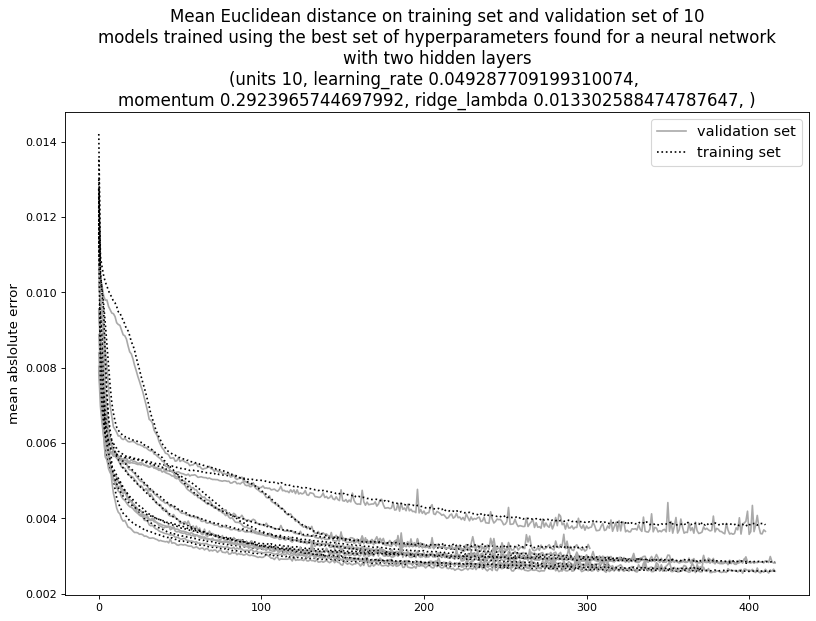

In [40]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']
    list_values_tr[i] = hist2[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png")
plt.show()

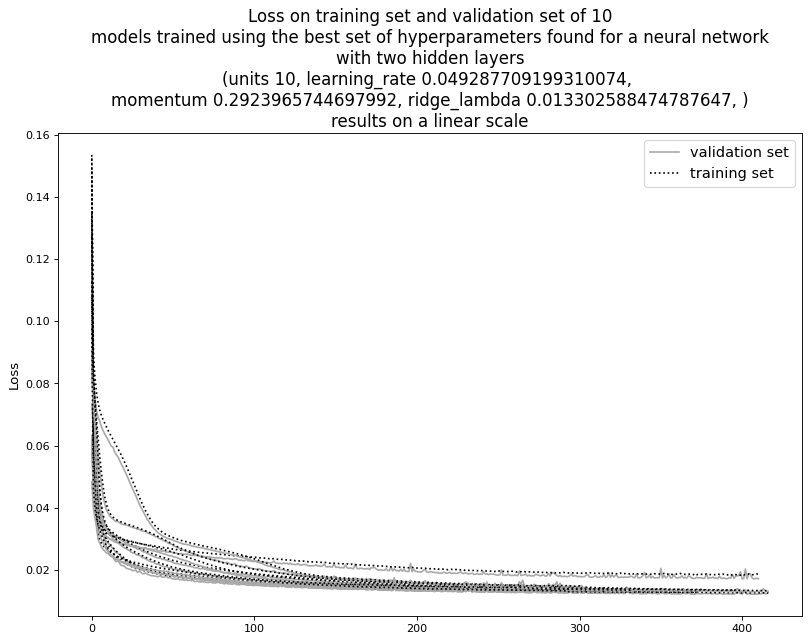

In [41]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

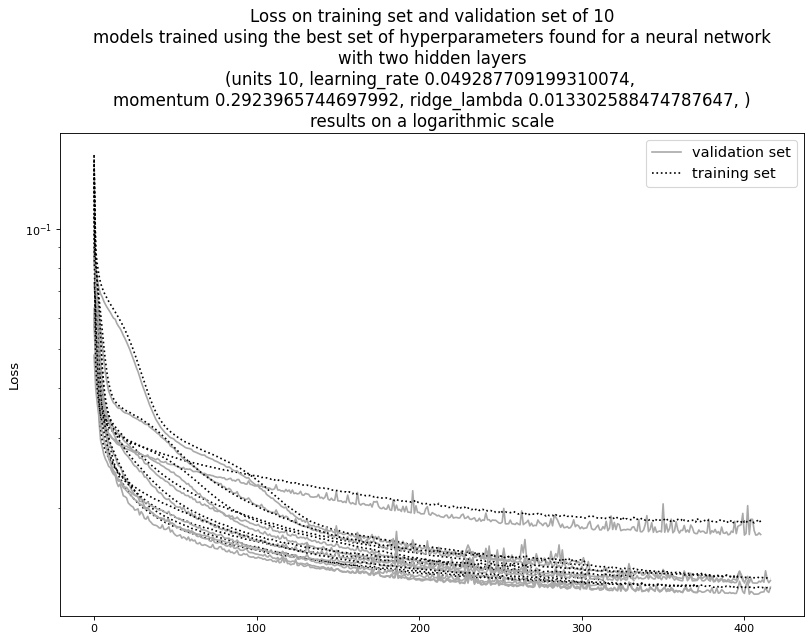

In [42]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

The neural networks with only one hidden layer have better results with respect to the others with two hidden layers. Therefore we decided to return a model among the ones obtained using a single hidden layer.  To retrieve a final model among the ones obtained using a random search, we chose the average model (among those having a single hidden layer) in terms of mean absolute error
on the validation set

In [43]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[int(n_trials/2)][1]

avg_model_val_err = hist[index].history['val_euclidean_distance']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "The validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model = models[index]
avg_model.save("results/ml_cup/nn_RandomSearch/avg_model_single_layer/")

The validation error on the final model for NN with random search is 0.002883685054257512

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_single_layer/assets


In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [44]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

print(len(x_mlcup_tr))

predicted_target_tr = avg_model.predict(x_mlcup_tr)

1492
47/47 [==============================] - 0s 670us/step


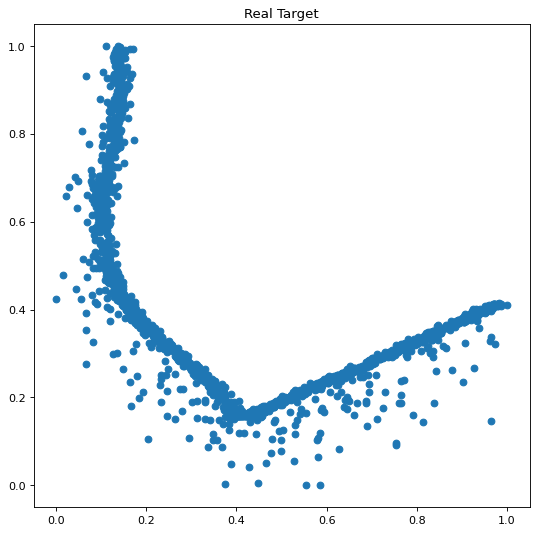

In [45]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.title("Real Target")
plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

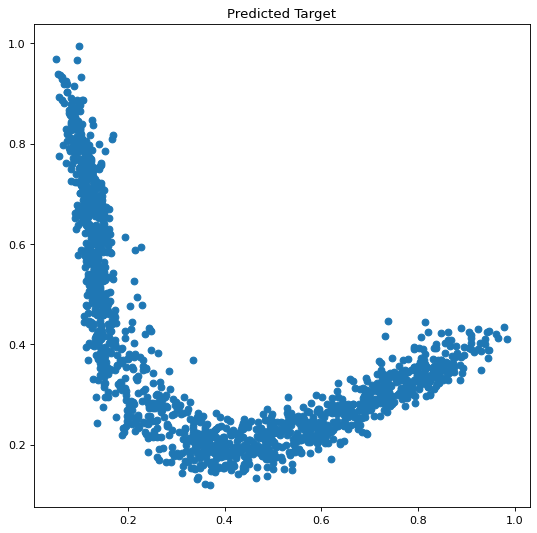

In [47]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1])
plt.title("Predicted Target")
plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_target.png")
plt.show()